# Exploration des données

In [244]:
# tous les modules nécessaires

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils import compute_class_weight

from tensorflow import keras

from xgboost import XGBClassifier

In [2]:
# charge les données

X = pd.read_csv("data/input_training.csv", index_col=0)
y = pd.read_csv("data/output_training_gmEd6Zt.csv", index_col=0)

X.head()

,day,equity,r0,r1,r2,r3,r4,r5,r6,r7,...,r43,r44,r45,r46,r47,r48,r49,r50,r51,r52
ID,,,,,,,,,,,,,,,,,,,,,
0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,-68.03,...,0.00,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00
1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,12.08,...,-4.83,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68
2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,53.61,...,-6.37,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96
3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,-47.57,...,-5.36,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43


In [3]:
X.shape, y.shape

((843299, 55), (843299, 1))

In [4]:
# combien de jours et combien d’actions différents
X.day.nunique(), X.equity.nunique()

(503, 1829)

In [241]:
# distribution des classes

y.reod.value_counts() / y.shape[0]

 0    0.412031
-1    0.300770
 1    0.287199
Name: reod, dtype: float64

In [5]:
X.iloc[0][:10]

day        249.00
equity    1488.00
r0           0.00
r1            NaN
r2            NaN
r3            NaN
r4           0.00
r5            NaN
r6            NaN
r7         -68.03
Name: 0, dtype: float64

In [6]:
y.reod[:5]

ID
0    0
1    0
2   -1
3    0
4   -1
Name: reod, dtype: int64

In [7]:
X.isna().sum(axis=1).agg(["mean", "std", "max"])

mean     5.707015
std     12.213529
max     53.000000
dtype: float64

In [8]:
X.shape

(843299, 55)

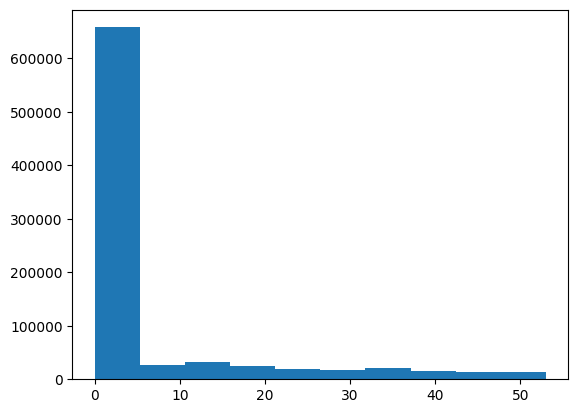

In [9]:
na_count = X.isna().sum(axis=1)
plt.hist(na_count, bins=10)
plt.savefig("images/hist_na.png")

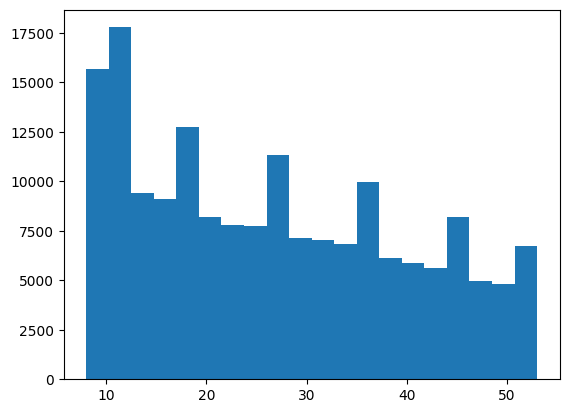

In [10]:
cond = na_count > 7
plt.hist(na_count[cond], bins=20)
plt.savefig("images/hist_na_ge7.png")

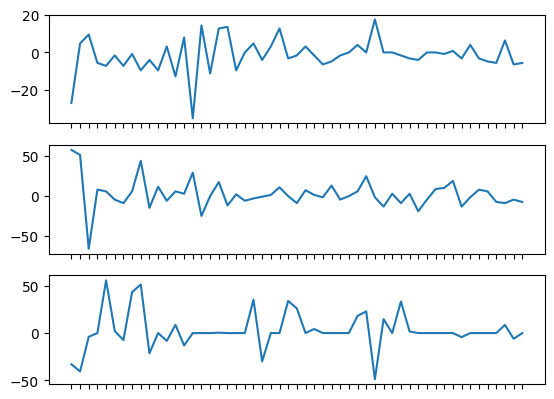

In [11]:
fig, axes = plt.subplots(3, 1)
for ax, i in zip(axes, [5, 10, 15]):
    ax.plot(X.iloc[i].drop(["day", "equity"]))
    ax.set_xticklabels([])
plt.savefig("images/obs.png")

In [12]:
# regroupe selon la classe

down = X[y.reod == -1]
stable = X[y.reod == 0]
up = X[y.reod==1]

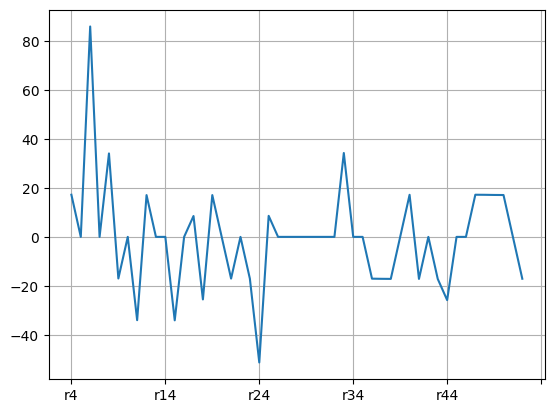

In [13]:
down.dropna(axis=0).iloc[5, 6:].plot(grid=True)
plt.savefig("images/down.png")

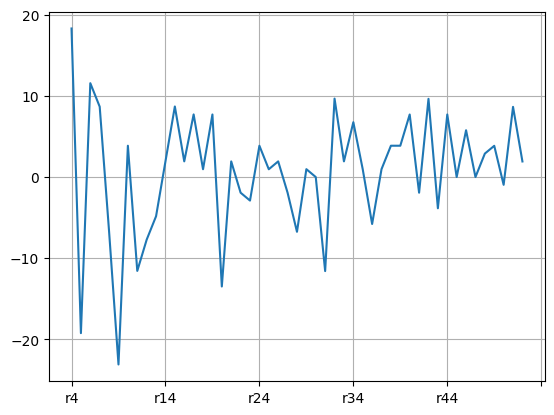

In [14]:
stable.dropna(axis=0).iloc[4, 6:].plot(grid=True)
plt.savefig("images/stable.png")

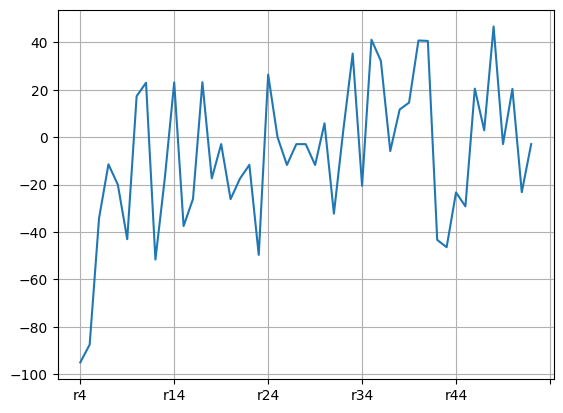

In [15]:
up.dropna(axis=0).iloc[12, 6:].plot(grid=True)
plt.savefig("images/up.png")

In [16]:
# les premiers rendements ne suivent pas la même distribution que les autres
columns = X.columns.to_list()[2:17]
X[columns].agg(["mean", "min", "max", "std"])

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14
mean,1.839875e+03,1.935344e+02,7.011399e+01,1.956448e+01,-0.215511,0.283935,-0.313301,-1.195195,-0.811229,0.405408,0.372729,0.311265,-0.041294,-0.644864,0.330377
min,-9.967670e+03,-9.973540e+03,-4.823740e+03,-1.949690e+03,-1390.130000,-1632.290000,-1559.320000,-2066.670000,-1359.000000,-1390.420000,-1647.060000,-1785.710000,-1159.840000,-1261.850000,-1713.930000
max,4.310700e+08,7.516000e+07,4.789000e+07,1.545000e+07,2327.870000,2396.690000,2343.750000,2733.810000,1477.440000,2462.310000,2951.810000,1779.450000,2000.000000,2000.000000,1692.310000
std,6.097548e+05,1.153271e+05,5.588823e+04,1.785055e+04,44.724646,41.548517,40.706372,38.327389,36.044397,34.341933,33.535457,32.124559,32.183368,31.116554,30.102509


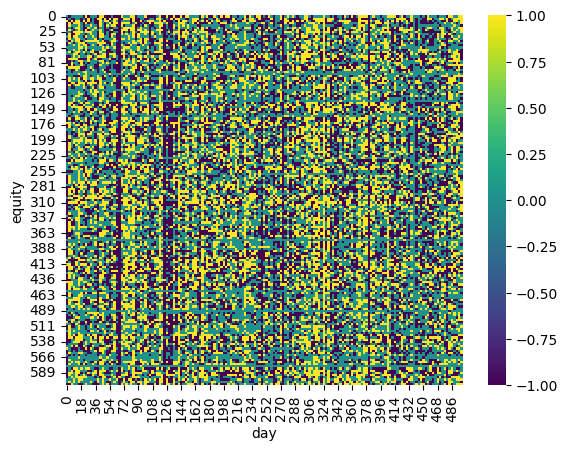

In [17]:
# affiche les classes selon les jours et les actions (on a enlevé les 
# valeurs manquantes pour l’affichage)

heatmap_data = X.merge(y, on="ID").pivot_table(
    index="equity", columns="day", values="reod"
).dropna()
sns.heatmap(
    heatmap_data.iloc[0:500:3, 0:500:3],
    cmap=plt.cm.viridis
)
plt.savefig("images/heatmap.png")

# Préparation

In [18]:
def get_agg_returns(X):
    """agrège les rendements sur des périodes de 7 * 5 = 35 minutes"""
    return_cols = X.columns[6:]
    new_X = pd.DataFrame()
    new_X["day"] = X.day
    new_X["equity"] = X.equity
    for i in range(7):
        columns = return_cols[i*7:(i+1)*7]  # colonnes à agréger
        ar = X[columns].mean(axis=1)
        name = f"ar{i+1}"
        new_X[name] = ar
    return new_X

In [274]:
# on sépare les données (le paramètre random_state permet de faire la même
# séparation peu importe les machines)

X_train, X_val, y_train, y_val = train_test_split(
    get_agg_returns(X.fillna(0)),
    y,
    test_size=0.2,
    random_state=42
)

# normalise les données après les avoir agrégées

scaler = StandardScaler()

def clean_targets(targets):
    return targets.reod.replace(-1, 2).values

X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
y_train = clean_targets(y_train)
y_val = clean_targets(y_val)

X_train

array([[ 0.69603205,  1.4755325 ,  1.68238   , ...,  1.0694578 ,
         0.79946154,  0.3812988 ],
       [-1.5480726 , -0.94605505, -1.0086241 , ...,  0.08037206,
        -0.3030166 , -1.6936911 ],
       [ 0.42756554,  1.6483674 ,  0.08378129, ...,  0.13631664,
        -0.12210421, -0.3087136 ],
       ...,
       [ 1.5427341 ,  0.0548678 , -0.21553215, ...,  1.1190035 ,
         0.56793326, -0.45610642],
       [ 0.19351783,  0.8297758 ,  0.5659795 , ...,  1.4276129 ,
         0.80064785,  2.0454113 ],
       [-0.33653143, -0.4693347 ,  1.8042337 , ...,  0.11200086,
        -0.09481905, -1.3828586 ]], dtype=float32)

In [100]:
y_train

array([2, 2, 1, ..., 0, 0, 0], dtype=int64)

In [101]:
# optionnellement, on peut one-hot encoder nos classes (on ne le fera
# pas ici)

enc = OneHotEncoder(sparse_output=False)
y_encoded = enc.fit_transform(y)
y_encoded[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [102]:
enc.categories_

[array([-1,  0,  1], dtype=int64)]

# Forêts aléatoires

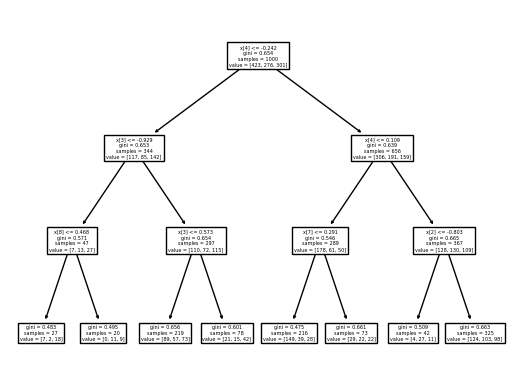

In [26]:
# un arbre de classification simple

X_subset, y_subset = X_train[:1000], y_train[:1000]
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_subset, y_subset)
tree.plot_tree(clf)
plt.savefig("images/tree.png")

In [32]:
# première forêt avec 20 arbres et une profondeur max de 5

forest = RandomForestClassifier(n_estimators=20, max_depth=5)
forest.fit(X_train, y_train)
preds_rf = forest.predict(X_val)

In [33]:
preds_rf

array([2, 0, 0, ..., 0, 0, 1], dtype=int64)

In [34]:
y_val

array([2, 1, 2, ..., 0, 2, 2], dtype=int64)

In [35]:
# pour éviter les codes dupliqués

def plot_cm(targets, preds, filename):
    """trace la matrice de confusion"""
    sns.heatmap(
        confusion_matrix(y_val, preds),
        annot=True,
        cbar=False,
        fmt=".0f",
        cmap=plt.cm.viridis
    )
    plt.savefig(filename)

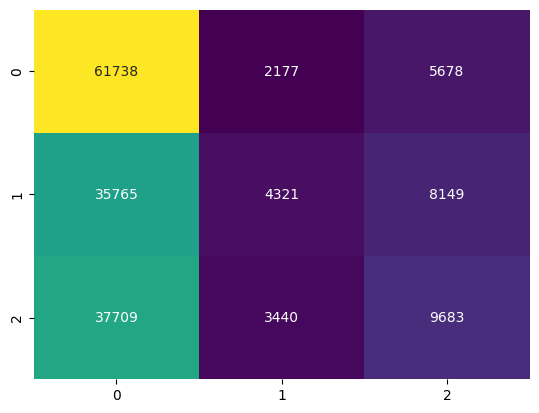

In [36]:
plot_cm(y_val, preds_rf, "images/cm_rf.png")

In [37]:
forest.score(X_val, y_val)

0.44908099134353135

In [253]:
# class weight pour le random forest

y_full = y.reod.replace(-1, 2).values
class_weight = dict(enumerate(compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_full),
    y=y_full
)))
class_weight

{0: 0.8090013862307475, 1: 1.1606336491945195, 2: 1.1082667360566265}

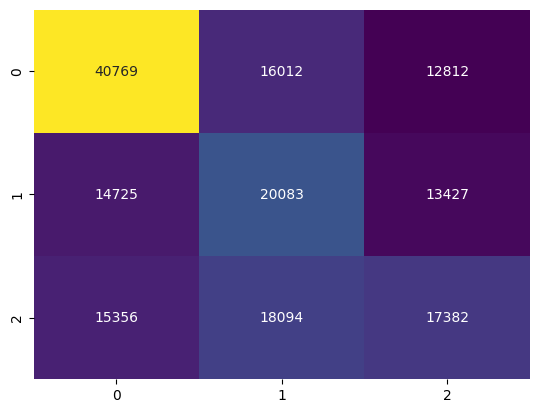

In [254]:
forest = RandomForestClassifier(
    n_estimators=20,
    max_depth=5,
    class_weight=class_weight
)
forest.fit(X_train, y_train)
preds_rf = forest.predict(X_val)
plot_cm(y_val, preds_rf, "images/cm_rf_weight.png")

Le classifeur fait maintenant de bien meilleures prédictions pour les classes 1 et 2.

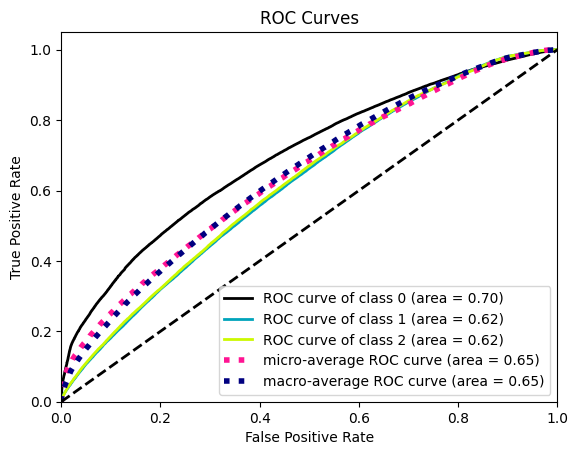

In [255]:
# on utilise predict_proba pour retourner un vecteur de probabilité plutôt
# que la classe prédite directement, nécessaire pour tracer les courbes ROC

preds = forest.predict_proba(X_val)
skplt.metrics.plot_roc(y_val, preds)
plt.savefig("images/roc_rf.png")

In [39]:
# on évalue pour différents paramètres

rf_results = {}
for n_estim in [1, 2, 3, 5, 10, 15, 20]:
    forest = RandomForestClassifier(n_estimators=n_estim, max_depth=7)
    forest.fit(X_train, y_train)
    train_score = round(forest.score(X_train, y_train), 2)
    val_score = round(forest.score(X_val, y_val), 2)
    rf_results[n_estim] = {"train": train_score, "val": val_score}

In [40]:
rf_results

{1: {'train': 0.45, 'val': 0.45},
 2: {'train': 0.45, 'val': 0.45},
 3: {'train': 0.45, 'val': 0.45},
 5: {'train': 0.46, 'val': 0.46},
 10: {'train': 0.46, 'val': 0.46},
 15: {'train': 0.46, 'val': 0.46},
 20: {'train': 0.46, 'val': 0.46}}

In [41]:
params = {
    "n_estimators": [1, 2, 5, 10, 20],
    "max_depth": [3, 5]
}
search = GridSearchCV(
    RandomForestClassifier(),
    params,
    cv=2,
    n_jobs=-1
)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 5, 'n_estimators': 20}

# Gradient boosted trees

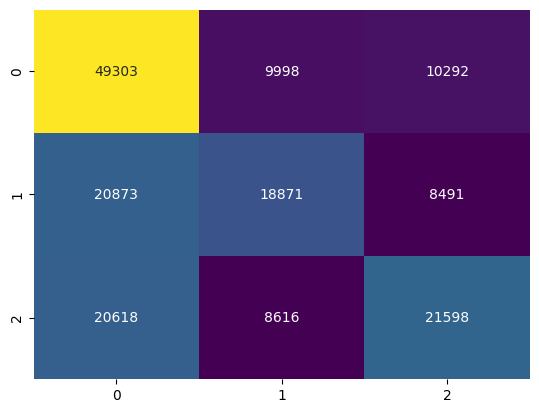

In [277]:
# gradient boosted trees simple avec la bibliothèque xgboost

bst = XGBClassifier(
    n_estimators=20,
    max_depth=10,
    n_jobs=-1,
)
bst.fit(X_train, y_train)
preds_bst = bst.predict(X_val)
plot_cm(y_val, preds_bst, "images/cm_bst")

In [278]:
# 53% contre 46 pour un random forest
accuracy_score(y_val, preds_bst)

0.5322660974742085

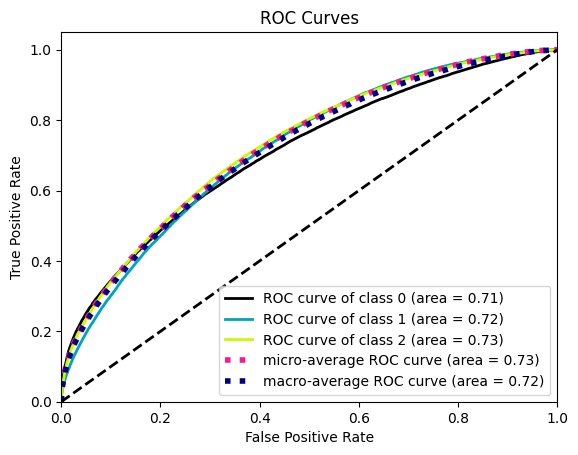

In [279]:
preds_bst = bst.predict_proba(X_val)
skplt.metrics.plot_roc(y_val, preds_bst)
plt.savefig("images/roc_bst.png")

# Réseaux de neurones

In [216]:
def plot_metrics(history, filename, accuracy=False):
    """pour tracer la loss et l’accuracy facilement"""
    metric_name = "accuracy" if accuracy else "loss"
    train = history.history[metric_name]
    val = history.history[f"val_{metric_name}"]
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, label=f"Training {metric_name}")
    plt.plot(epochs, val, label=f"Validation {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric_name.title()}")
    plt.grid()
    plt.legend()
    plt.title(f"{metric_name.title()} during training")
    plt.savefig(filename)

In [225]:
# on utilise tous les rendements
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
y_train = clean_targets(y_train)
y_val = clean_targets(y_val)

num_epochs = 50

In [261]:
# modèle très simple

model_1 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

optimizer = keras.optimizers.RMSprop(
    learning_rate=0.001,
    momentum=0.1
)

model_1.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_1 = model_1.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=1024,
    validation_split=0.2,
    class_weight=class_weight
)

Epoch 1/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0678 - accuracy: 0.4329 - val_loss: 1.0486 - val_accuracy: 0.4370
Epoch 2/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0436 - accuracy: 0.4483 - val_loss: 1.0389 - val_accuracy: 0.4495
Epoch 3/25
528/528 [==============================] - 2s 5ms/step - loss: 1.0347 - accuracy: 0.4585 - val_loss: 1.0297 - val_accuracy: 0.4594
Epoch 4/25
528/528 [==============================] - 2s 4ms/step - loss: 1.0272 - accuracy: 0.4672 - val_loss: 1.0303 - val_accuracy: 0.4588
Epoch 5/25
528/528 [==============================] - 2s 4ms/step - loss: 1.0211 - accuracy: 0.4741 - val_loss: 1.0269 - val_accuracy: 0.4636
Epoch 6/25
528/528 [==============================] - 2s 4ms/step - loss: 1.0166 - accuracy: 0.4786 - val_loss: 1.0260 - val_accuracy: 0.4650
Epoch 7/25
528/528 [==============================] - 2s 4ms/step - loss: 1.0123 - accuracy: 0.4827 - val_loss: 1.0277 - val_accuracy: 0.4660
Epoch 

In [272]:
model_1.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 128)               7168      
                                                                 
 dense_148 (Dense)           (None, 128)               16512     
                                                                 
 dense_149 (Dense)           (None, 3)                 387       
                                                                 
Total params: 24,067
Trainable params: 24,067
Non-trainable params: 0
_________________________________________________________________


In [267]:
model_1.evaluate(X_val, y_val)

5271/5271 [==============================] - 14s 3ms/step - loss: 1.1082 - accuracy: 0.4704


[1.1081582307815552, 0.47043755650520325]

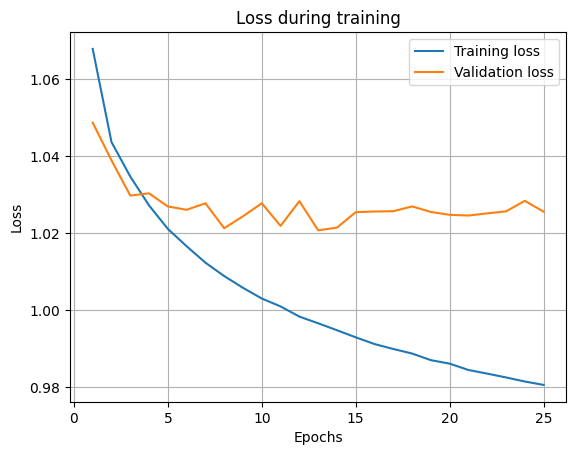

In [262]:
plot_metrics(history_1, "images/loss_1.png")

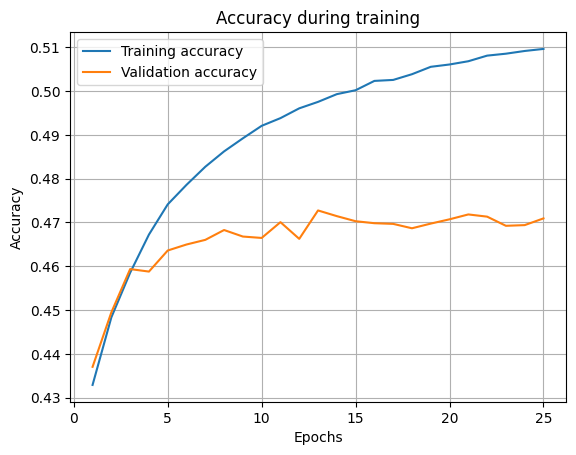

In [263]:
plot_metrics(history_1, "images/accuracy_1.png", accuracy=True)

In [266]:
# on peut adapter le learning_rate au cours au cours de l’entraînement
# et tout arrêter automatiquement dès que le modèle ne s’améliore plus

model_2 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

model_2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks=[
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=3,
        factor=0.2,
        min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10
    ),
    keras.callbacks.TensorBoard(
        log_dir="logs/"
    )
]

history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.2,
    class_weight=class_weight
)

Epoch 1/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0567 - accuracy: 0.4355 - val_loss: 1.0379 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 2/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0353 - accuracy: 0.4544 - val_loss: 1.0313 - val_accuracy: 0.4525 - lr: 0.0010
Epoch 3/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0257 - accuracy: 0.4643 - val_loss: 1.0287 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 4/25
528/528 [==============================] - 2s 5ms/step - loss: 1.0181 - accuracy: 0.4727 - val_loss: 1.0251 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 5/25
528/528 [==============================] - 2s 5ms/step - loss: 1.0123 - accuracy: 0.4783 - val_loss: 1.0224 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 6/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0075 - accuracy: 0.4832 - val_loss: 1.0250 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 7/25
528/528 [==============================] - 3s 5ms/step - lo

In [268]:
model_2.evaluate(X_val, y_val)

5271/5271 [==============================] - 14s 3ms/step - loss: 1.1875 - accuracy: 0.4705


[1.1874797344207764, 0.47047314047813416]

In [269]:
model_3 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),  # avec du Dropout cette fois
    keras.layers.Dense(3, activation="softmax")
])

model_3.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_3 = model_3.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=1024,
    validation_split=0.2,
    class_weight=class_weight
)

Epoch 1/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0998 - accuracy: 0.3998 - val_loss: 1.0811 - val_accuracy: 0.4300
Epoch 2/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0785 - accuracy: 0.4290 - val_loss: 1.0704 - val_accuracy: 0.4385
Epoch 3/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0717 - accuracy: 0.4344 - val_loss: 1.0624 - val_accuracy: 0.4406
Epoch 4/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0656 - accuracy: 0.4366 - val_loss: 1.0568 - val_accuracy: 0.4391
Epoch 5/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0610 - accuracy: 0.4362 - val_loss: 1.0529 - val_accuracy: 0.4374
Epoch 6/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0580 - accuracy: 0.4361 - val_loss: 1.0513 - val_accuracy: 0.4344
Epoch 7/25
528/528 [==============================] - 3s 5ms/step - loss: 1.0559 - accuracy: 0.4346 - val_loss: 1.0491 - val_accuracy: 0.4346
Epoch 

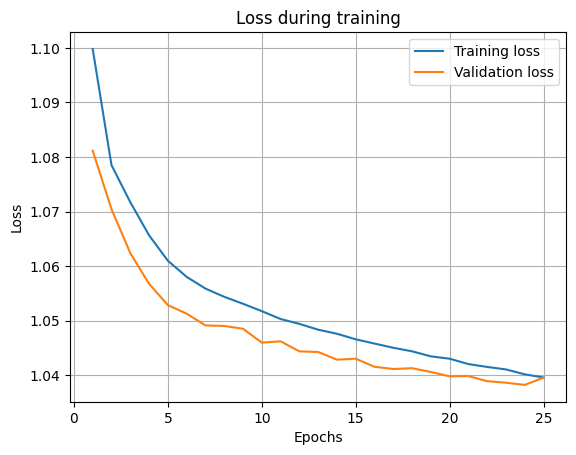

In [270]:
plot_metrics(history_3, "images/loss_2.png")

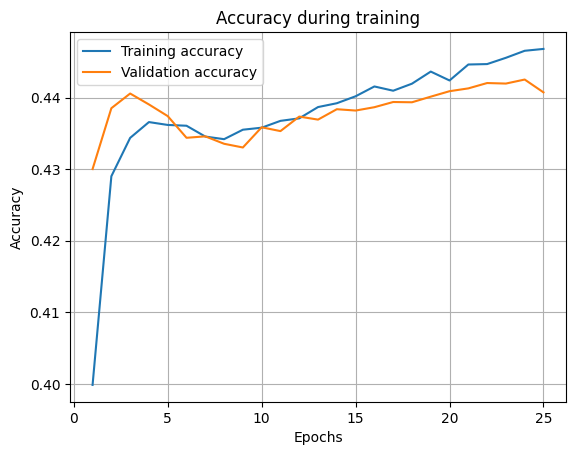

In [271]:
plot_metrics(history_3, "images/accuracy_2.png", accuracy=True)

In [238]:
model_3.evaluate(X_val, y_val)

5271/5271 [==============================] - 14s 3ms/step - loss: 1.4241 - accuracy: 0.4890


[1.4240772724151611, 0.4889659583568573]